### [Implementing the Most Popular Indicator on TradingView Using Python](https://medium.com/geekculture/implementing-the-most-popular-indicator-on-tradingview-using-python-239d579412ab)

[**LazyBear 的擠壓動量指標**](https://www.tradingview.com/script/nqQ1DT5a-Squeeze-Momentum-Indicator-LazyBear/) <br>

* (多頭頭寸):當黑色十字變成灰色且柱線呈淺綠色時買入（表示擠壓釋放且動量為正），當柱線變為深綠色時（開始失去看漲勢頭時）賣出<br>
* (空頭頭寸):當黑色十字變為灰色且柱線呈淺紅色時買入（表示擠壓已關閉且動量為負），當柱線變為深紅色時（當它開始失去看跌勢頭時）賣出

* Determine whether the color of the cross is black or gray: squeezed or not squeezed 判斷十字的顏色是黑色還是灰色：擠壓或不擠壓<br>
* Determine whether the bar is of dark or light color: gaining or losing momentum 確定柱是深色還是淺色：獲得或失去動力<br>
* Find out whether a buying window has appeared: squeeze has been released 查看是否出現買入窗口：擠壓已解除<br>

In [2]:
# 導入所需的庫
import pandas as pd
import yfinance as yf
import numpy as np
import math

In [3]:
# 參數設置（原始指標中的默認值）
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5

# 獲取股票價格
df = yf.download('AAPL', start='2020-01-01', threads= False)

[*********************100%***********************]  1 of 1 completed


#### Squeeze
Using Bollinger Bands (BB) and Keltner Channel (KC) to compute the following two technical indicators to determine the ‘squeezing’ part.

In [4]:
# calculate Bollinger Bands 計算布林帶
# moving average 移動平均線
m_avg = df['Close'].rolling(window=length).mean()

# standard deviation 標準差
m_std = df['Close'].rolling(window=length).std(ddof=0)

# upper Bollinger Bands 上布林帶
df['upper_BB'] = m_avg + mult * m_std

# lower Bollinger Bands 下布林帶
df['lower_BB'] = m_avg - mult * m_std

計算真實範圍 (TR) <br>
* 今天的高點減去今天的低點 <br>
* 今日高點減去昨日收盤價的絕對值 <br>
* 今日低點減去昨日收盤價的絕對值 <br>

In [5]:
# calculate Keltner Channel 計算 Keltner 通道

# first we need to calculate True Range
df['tr0'] = abs(df["High"] - df["Low"])
df['tr1'] = abs(df["High"] - df["Close"].shift())
df['tr2'] = abs(df["Low"] - df["Close"].shift())
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

# moving average of the TR (TR 移動平均)
range_ma = df['tr'].rolling(window=length_KC).mean()

# upper Keltner Channel (上 Keltner 通道)
df['upper_KC'] = m_avg + range_ma * mult_KC

# lower Keltner Channel (下 Keltner 通道)
df['lower_KC'] = m_avg - range_ma * mult_KC

* Squeeze on: The market is in a squeeze (BB are within the KC) => BB 在 KC 內 <br>
* Squeeze off: The squeeze is released (BB are outside of the KC) => BB 在 KC 之外

In [6]:
# 檢查'squeeze'
df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

In [7]:
# 計算動量值
high = df['High'].rolling(window = length_KC).max()
minimum= df['Low'].rolling(window = length_KC).min()
m1 = (high + minimum) / 2
df['value'] = (df['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df['value'] = df['value'] .rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
np.polyfit(fit_y, x, 1)[1], raw=True )

#### Entry Point

In [9]:
# 多頭入場點：
# 1. 黑十字變灰（擠壓解除）
long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)

 # 2. 柱值為正 => 柱為淺綠色
long_cond2 = df['value'][-1] > 0
enter_long = long_cond1 & long_cond2
# 空頭入場點：
# 1. 黑十字變灰（擠壓解除）
short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
 # 2. 柱值為負 => 柱為淺紅色
short_cond2 = df['value'][-1] < 0
enter_short = short_cond1 & short_cond2

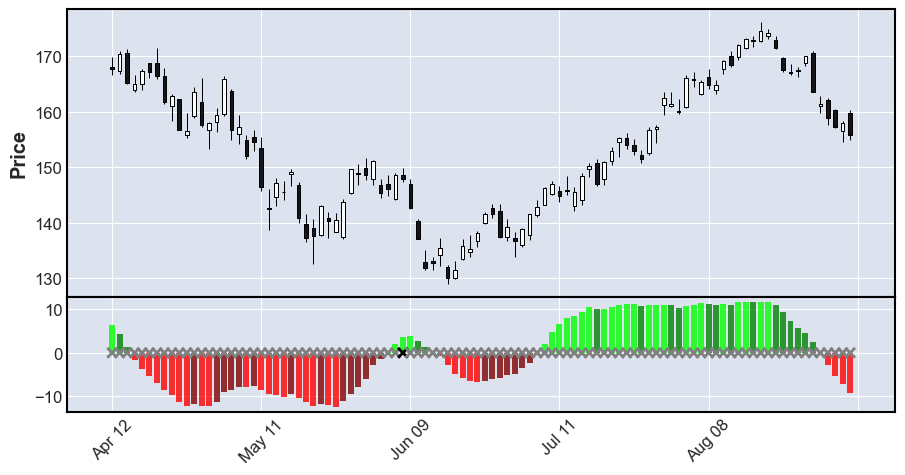

In [10]:
# we are using mplfinance to help us visualize the indicator
import mplfinance as mpf

# to make the visualization better by only taking the last 100 rows of data
df = df[-100:]

# extract only ['Open', 'High', 'Close', 'Low'] from df
ohcl = df[['Open', 'High', 'Close', 'Low']]

# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df['value']):
  if val >= 0:
    color = 'green'
    if val > df['value'][ind-1]:
      color = 'lime'
  else:
    color = 'maroon'
    if val < df['value'][ind-1]:
      color='red'
  colors.append(color)
  
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in df['squeeze_off']], secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1, 
              type='candle', 
              addplot=apds,
              returnfig=True)

#### Screening 篩選

In [12]:
import requests
import yfinance as yf
# 貼上連結
url = 'https://www.slickcharts.com/sp500'
headers = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

request = requests.get(url, headers = headers)

data = pd.read_html(request.text)[0]

# 欄位『Symbol』就是股票代碼
stk_list = data.Symbol

# 用 replace 將符號進行替換
SP500_list = data.Symbol.apply(lambda x: x.replace('.', '-'))

In [13]:
screened_list = []
stock_list = ['AAPL','TSLA','MSFT','AMZN']
for stock_code in SP500_list:
  # get stock prices
  df = yf.download(stock_code, start='2020-01-01', threads= False)
  
  # put all the previous codes (line 10-59) here
  
  if enter_long | enter_short:
    screened_list.append(stock_code)
if screened_list:
  print(screened_list)
else:
  print('No stock fits the indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********